This notebook looks at rosettes that had a bug in the generation process (residual) and attempts to re-create them.

In [1]:
# import packages
import numpy as np
import cadquery as cq
from scipy.stats import qmc
import math
import itertools
import matplotlib.pyplot as plt
import os, re, shutil
import json
import copy
import random
import sys
import miniball
import pandas as pd
import glob
import contextlib

# Source code

In [2]:
# Helper functions from helper.py
def norm_rows(v):
    """Normalize rows of array v into unit vectors."""
    if np.all(v==0):
        v_unit = np.array([1,0,0])
    else:
        if v.ndim == 1:
            v_norm = np.linalg.norm(v)
            v_unit = v/v_norm
        
        else:
            v_norm = np.linalg.norm(v, axis=1)
            v_unit = v/v_norm[:,None]
    return v_unit

def random_spherical_cap(cone_angle_deg, cone_direction, num_points):
    """
    Generates a desired number of random points on a spherical cap, 
    given a solid angle and cone direction.

    Parameters
    ----------
    cone_angle_deg : float
        Solid angle of the cone used to define the spherical cap, in units of degrees.
    cone_direction : list
        Direction of cone as a list of vector components [x, y, z].
    num_points : int
        Number of points to generate on spherical cap. 
    
    Returns
    ----------
    points_rot 
        List of random points on spherical cap, as numpy array. 
    """
    # generate points on spherical cap centered at north pole
    cone_angle_rad = cone_angle_deg*(np.pi/180)
    z = np.random.uniform(np.cos(cone_angle_rad), 1, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)
    x = np.sqrt(1-z**2)*np.cos(phi)
    y = np.sqrt(1-z**2)*np.sin(phi)
    points = np.column_stack((x, y, z))

    # rotate points
    north_vector = np.array([0, 0, 1])
    cone_direction_norm = norm_rows(cone_direction)
    u = norm_rows(np.cross(north_vector, cone_direction_norm)) # rotation axis
    rot = np.arccos(np.dot(cone_direction_norm, north_vector)) # rotation angle in radians
    ux = u[0]
    uy = u[1]
    uz = u[2]
    # define rotation matrix
    r11 = np.cos(rot) + (ux**2)*(1 - np.cos(rot))
    r12 = ux*uy*(1 - np.cos(rot)) - uz*np.sin(rot)
    r13 = ux*uz*(1 - np.cos(rot)) + uy*np.sin(rot)
    r21 = uy*ux*(1 - np.cos(rot)) + uz*np.sin(rot)
    r22 = np.cos(rot) + (uy**2)*(1 - np.cos(rot))
    r23 = uy*uz*(1 - np.cos(rot)) - ux*np.sin(rot)
    r31 = uz*ux*(1 - np.cos(rot)) - uy*np.sin(rot)
    r32 = uz*uy*(1 - np.cos(rot)) + ux*np.sin(rot)
    r33 = np.cos(rot) + (uz**2)*(1 - np.cos(rot))
    rot_mat = np.array([[r11, r12, r13], 
                        [r21, r22, r23], 
                        [r31, r32, r33]])
    
    points_rot = np.matmul(rot_mat, points.T)
    points_rot = points_rot.T   

    return points_rot
def perturb_aspect_ratio(n_arms, f_a_c_limits):
    f_a_c = []
    for i in range(n_arms):
        f_a = random.uniform(f_a_c_limits[0], f_a_c_limits[1])
        f_c = random.uniform(f_a_c_limits[2], f_a_c_limits[3])
        f_a_c.append(f_a)
        f_a_c.append(f_c)
    return f_a_c

def get_cone_angle(n_arms):
    # source: http://neilsloane.com/packings/index.html#I
    min_angles = {4 : 109.4712206, 
                  5 : 90.0000000, 
                  6 : 90.0000000, 
                  7 : 77.8695421,
                  8 : 74.8584922,
                  9 : 70.5287794,
                  10 : 66.1468220}
    cone_angle_deg = min_angles[n_arms]/3 # adjust as needed
    return cone_angle_deg

def perturb_s_code(n_arms, s_code_dict):
    s_code = s_code_dict[str(n_arms)]
    s_code_perturbed = []
    cone_angle_deg = get_cone_angle(n_arms)
    for i in range(n_arms):
        cone_direction = np.array([s_code[3*i], s_code[3*i+1], s_code[3*i+2]])
        points_rot = random_spherical_cap(cone_angle_deg, cone_direction, 1)
        pt = points_rot[0]
        s_code_perturbed.extend(pt)
    return s_code_perturbed

In [3]:
### =========== (Rosette code) =========== ###
def create_bullet(a, c, hp, f_a, f_c, workplane):
    # create pyramid
    n_pyr = 6
    ri = a*np.cos(np.radians(30)) # distance between center and edge of hexagon
    theta = 90 - np.degrees(np.arctan(hp/ri))
    pyramid = workplane.polygon(n_pyr, f_a*2*a).extrude(-f_a*hp, taper=theta)
    # create cylinder 
    n_cyl = 6
    cylinder = workplane.polygon(n_cyl, f_a*2*a).extrude(f_c*2*c)
    # create bullet (union)
    bullet = cylinder.union(pyramid)
    return bullet

def calc_r0(f_r0, a, n_arms):
    '''
    linearly interpolate between perscribed limits for r0
    '''
    ymin, ymax = 0.5*a, 1*a
    xmin, xmax = 4, 12
    slope = (ymax-ymin)/(xmax-xmin)
    intercept = ymin - (slope*xmin)
    r0 = slope*(n_arms) + intercept
    r0 = f_r0 * r0 # multiply by perturbation factor
    return r0 

def calc_hp(f_hp, r0, n_arms):
    '''
    linearly interpolate: hp increases with n_arms
    '''
    ymin, ymax = 1*r0, 1.5*r0
    xmin, xmax = 4, 12
    slope = (ymax-ymin)/(xmax-xmin)
    intercept = ymin - (slope*xmin)
    hp = slope*(n_arms) + intercept
    hp = f_hp*hp # multiply by perturbation factot
    return hp

def calc_h0(f_h0, r0):
    '''
    h0 calculate as a perscribed fraction of r0
    '''
    h0 = r0/2
    h0 = f_h0*h0 # multiply by perturbation factor
    return h0

def extract_xyz(s_code):
    '''
    Convert list in format [x1, y1, z1, ..., xn, yn, zn] to separate x, y, z arrays
    '''
    x = []
    y = []
    z = []
    for i in range(0, len(s_code), 3):
        x.append(s_code[i])
        y.append(s_code[i+1])
        z.append(s_code[i+2])
    return x, y, z

# create_ros(base_params, n_arms, s_code, aspect_perturb)
def create_ros(params, n_arms, s_code, aspect_perturb):
    '''
    aspect_perturb: list in form [f_a_1,f_c_1,...,f_a_n_arms,f_c_n_arms]
    '''
    # unpack parameters
    a, c, f_r0, f_hp, f_h0 = params[0], params[1], params[2], params[3], params[4]
    r0 = calc_r0(f_r0, a, n_arms)
    hp = calc_hp(f_hp, r0, n_arms)
    h0 = calc_h0(f_h0, r0)
    # create sphere
    sphere = cq.Workplane().sphere(r0)
    # create outer shell to "place" bullets on
    # based on spherical code from Sloane et al. 
    r_outer = r0 + hp - h0
    # convert s_code list to outer_coords
    x, y, z = extract_xyz(s_code)
    outer_coords = r_outer*(np.column_stack((x, y, z)))
    # create and collect bullets in list
    bullets = []
    for i in range(len(outer_coords)):
        f_a = aspect_perturb[2*i]
        f_c = aspect_perturb[2*i + 1]
        normal_vector = tuple(outer_coords[i])
        plane = cq.Plane(origin=normal_vector, normal=normal_vector)
        workplane = cq.Workplane(plane)
        bullet = create_bullet(a, c, hp, f_a, f_c, workplane)
        bullets.append(bullet)
    # boolean union to create rosette
    ros = sphere.union(bullets[0])
    for i in range(1, n_arms):
        ros = ros.union(bullets[i])
    return ros
### ====================================== ###
def get_verts(ros, threshold):
    verts = ros.vertices() # list of vertices 
    origin = cq.Vertex.makeVertex(0,0,0)
    # filtered_verts = [v for v in verts if v.distance(origin) > threshold/2]
    filtered_verts = [v for v in verts]
    final_verts = np.asarray([list(v.Center().toTuple()) for v in filtered_verts])
    return final_verts 
    
    
def calc_mbs(points):
    """
    Calculate minimal bounding sphere (mbs)
    """
    mbs = {} # store attributes of sphere as dict

    # use miniball algorithm to find bounding sphere
    # mesh_points = np.asarray(points)
    unique_pts = np.unique(points, axis=0)
    c, r2 = miniball.get_bounding_ball(unique_pts)
    r = np.sqrt(r2) # r2 = radius squared, r = radius

    mbs['c'] = c # center coordinates as np array
    mbs['r'] = r # radius of sphere as float
    mbs['v'] = (4/3)*np.pi*(r**3)
    mbs['a'] = 4*np.pi*(r**2) 

    return mbs

def get_record(ros, params, id):
    try:
        sa = ros.val().Area()
        vol = ros.val().Volume()
        base_params = params[0]
        # print(f'rosette {id}: {base_params}')
        points = get_verts(ros, base_params[2])
        mbs = calc_mbs(points)
        rho_eff = vol/mbs['v'] 
        sa_eff = sa/mbs['a']
        record = [id]
        record.extend(base_params)
        record.extend([sa, vol, sa_eff, rho_eff])
        return record
    except Exception as e:
        print(f'rosette {id}: {base_params}')
        return f"An unexpected error occurred: {e}"

def process_instance(params, i, save_dir):
    # extract params
    base_params = params[0][:5]
    n_arms = params[0][5]
    aspect_perturb = params[1]
    s_code = params[2]
    ros = create_ros(base_params, n_arms, s_code, aspect_perturb)
    # make stl and record dirs if they don't exist
    record_dir = save_dir + f'/data/{n_arms}'
    stl_dir = save_dir + f'/stl/{n_arms}'
    os.makedirs(record_dir, exist_ok=True)
    os.makedirs(stl_dir, exist_ok=True)
    # calc attributes and save record as txt
    record = get_record(ros, params, i)
    record_filename = f'record-ros-test-{i:06d}.txt'
    record_filepath = os.path.join(record_dir, record_filename)
    print(record_filepath)
    with open(record_filepath, 'w') as file:
        file.write(",".join(map(str, record))) 
    # save model
    save_filename = f'ros-test-{i:06d}.stl'
    save_filepath = os.path.join(stl_dir, save_filename)
    print(save_filepath)
    print(type(ros))
    cq.exporters.export(ros, save_filepath) # save file

def process_chunk(chunk, start_index, end_index, save_dir):
    for i in range(start_index, end_index):
        p = chunk[i]
        process_instance(p, i, save_dir)

# Identify residuals

In [13]:
# load the param file that was used to create rosettes
params_path = '/glade/u/home/joko/ice3d/output/params_200_50.json'
# load saved json
with open(params_path, 'rb') as file:
    params_list = json.load(file)

In [14]:
# load the generated rosette data
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/data/'
file_paths = glob.glob(data_dir + "*.txt")
dfs = []
for file in file_paths:
    df = pd.read_csv(file, delimiter=",", header=None)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
colnames = ['id', 'a', 'c', 'f_r0', 'f_hp', 'f_h0', 'n_arms', 'sa', 'vol', 'sa_eff', 'rho_eff']
df.columns = colnames
print(df.shape)
df.head()

(70000, 11)


,id,a,c,f_r0,f_hp,f_h0,n_arms,sa,vol,sa_eff,rho_eff
0,35000,13.817545,23.540122,0.867449,0.961225,0.943525,7,33247.371151,181231.947690,0.576030,0.138993
1,35001,13.817545,23.540122,0.867449,0.961225,0.943525,7,33022.961732,184536.198465,0.560433,0.137205
2,35002,13.817545,23.540122,0.867449,0.961225,0.943525,7,33530.598131,187678.178569,0.585745,0.145727
3,35003,13.817545,23.540122,0.867449,0.961225,0.943525,7,32592.037777,166089.393327,0.543729,0.120358
4,35004,13.817545,23.540122,0.867449,0.961225,0.943525,7,32892.678757,179534.751064,0.583751,0.142747


In [6]:
df[df.id==2]

,id,a,c,f_r0,f_hp,f_h0,n_arms,sa,vol,sa_eff,rho_eff
28002,2,19.677777,26.434892,0.922732,1.120977,1.199872,4,28141.658042,184010.203631,0.498019,0.145684


## Identify missing rosettes

Note: there were a couple issues with the exception block for create_ros()
- first, there was an unintended return statement in the exception block that caused the error code (-666) to never get appended to the data record, that's why we see NaNs instead of -666
- second, some rosettes may be technically "created" without a bug, but never saved because there is an issue with the object. I'm assuming some numerical issue, because reducing the number of significant digits of the input parameters seems to make the rosette generate without an issue.
- That's why the below code chunk is used to compare the existing ID's in stl directory and compare to the original parameter input list.

In [15]:
# Directory path
directory_path = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl/'

# Get all .stl files, including those in subdirectories
file_paths = glob.glob(directory_path + '**/*.stl', recursive=True)

# Initialize an empty list to store the gen_ids
gen_ids = []

# Regular expression to extract the number
pattern = r'ros-test-(\d+)\.stl'

# Loop through the files and extract the number
for file in file_paths:
    match = re.search(pattern, file)
    if match:
        # Extract the number and append it to the list
        number = match.group(1)
        gen_ids.append(int(number))  # Convert to integer if needed

# Print the list of gen_ids
print(len(gen_ids))

69998


In [16]:
full_ids = list(range(70000))
missing = list(set(full_ids) - set(gen_ids))
print(missing)

[25954, 9895]


In [8]:
print(df[df.id == missing[0]])
print(df[df.id == missing[1]])

          id          a           c      f_r0      f_hp      f_h0  n_arms  sa  \
39954  25954  24.003513  134.661889  0.819574  0.821878  0.901288       6 NaN   

       vol  sa_eff  rho_eff  
39954  NaN     NaN      NaN  
        id          a          c      f_r0      f_hp      f_h0  n_arms     sa  \
9895  9895  16.571058  84.161255  0.811206  1.140741  0.822291       4 -999.0   

        vol  sa_eff  rho_eff  
9895 -999.0  -999.0   -999.0  


### Generate new randomized rosette for missing rosettes

In [10]:
# get a randomized parameter set for rosettes with create_ros() error
for i in range(len(missing)):
    base_params = params_list[missing[i]][0] # set here
    n_arms = base_params[5]
    # load spherical code
    # Read the JSON file as a dictionary
    json_filepath = '/glade/u/home/joko/spherical-code/data/s_code.json'
    with open(json_filepath, 'r') as json_file:
        s_code_dict = json.load(json_file)
    # code to generate randomly perturbed parameter set 
    f_a_min, f_a_max = 0.8, 1.2
    f_c_min, f_c_max = 0.8, 1.2
    f_a_c_limits = [f_a_min, f_a_max, f_c_min, f_c_max]
    new_params = []
    # append base parameters
    new_params.append(base_params)
    # calculate (f_a, f_c) for each bullet
    f_a_c = perturb_aspect_ratio(n_arms, f_a_c_limits)
    new_params.append(f_a_c)
    # calculate perturbed spherical codes
    s_code_perturbed = perturb_s_code(n_arms, s_code_dict)
    new_params.append(s_code_perturbed)
    # generate rosette
    base_params = new_params[0][:5]
    n_arms = new_params[0][5]
    aspect_perturb = new_params[1]
    s_code = new_params[2]
    ros = create_ros(base_params, n_arms, s_code, aspect_perturb)
print('successfully created new random variants')

successfully created new random variants


### Re-generate missing rosettes with reduced precision parameters

Change the number of significant digits using round()

In [11]:
params = params_list[missing[0]] # set here
base_params = params[0][:5]
n_arms = params[0][5]
aspect_perturb = params[1]
s_code = params[2]
a, c = base_params[0], base_params[1]
f_r0 = round(base_params[2], 2)
f_hp = round(base_params[3], 2)
f_h0 = round(base_params[4], 2)

In [12]:
test = [round(i, 2) for i in base_params]
test

[24.0, 134.66, 0.82, 0.82, 0.9]

In [13]:
# for illustration, try to regenerate the missing rosettes with original parameters
save_dir = '/glade/derecho/scratch/joko/synth-ros/temp'
rosettes = {}
for i in range(len(missing)):
    id = missing[i]
    print(f'Missing ros id {id}')
    params = params_list[id] # set here
    base_params = params[0][:5]
    n_arms = params[0][5]
    aspect_perturb = params[1]
    s_code = params[2]
    print(base_params, n_arms, s_code, aspect_perturb)
    savepath = os.path.join(save_dir, f'ros-{id:06d}.stl')
    try: 
        ros = create_ros(base_params, n_arms, s_code, aspect_perturb) # create ros object
        rosettes[id] = ros
        print(f'saving to {savepath}')
        cq.exporters.export(ros, savepath) # save 
        try: 
            # try calculating mbs 
            points = get_verts(ros, base_params[2])
            mbs = calc_mbs(points)
        except Exception as e:
            print(f'Rosette {id} mbs_error: {e}')
        if os.path.exists(savepath):
            print(f'--> Rosette {id} re-generated successfully!')
        else:
            print(f'Rosette {id} was generated but not saved properly')
    except Exception as e:
        print(f'Rosette {id} not created, error: {e}')

Missing ros id 25954
[24.00351261407805, 134.66188864976206, 0.8195740666268079, 0.8218781981212082, 0.9012884550674822] 6 [0.38273767872535575, -0.8835269100212053, -0.26998531173437473, -0.9842013058275141, -0.15412102628885632, 0.0871464219752356, 0.07235495149582313, 0.9970074374919519, 0.027220040039811034, 0.993936120897774, 0.03217823583865214, -0.10514536943202815, 0.3333310627441758, 0.3131533459595148, 0.8892836355877684, 0.41678700836234667, -0.2040066753033841, -0.885815932399065] [1.0124765942373992, 0.8013441748214285, 0.8395033153883997, 1.1497465222033447, 0.9096167814258856, 0.8731638652690399, 1.1744324682473006, 1.14891592088879, 1.06850572898942, 0.9868855991611052, 1.1018381678172595, 1.1086557778512371]
Rosette 25954 not created, error: Courbes non jointives
Missing ros id 9895
[16.57105832530715, 84.1612554053567, 0.811205947493316, 1.1407413278945557, 0.8222911201885716] 4 [-0.4257084105267138, 0.8836568935359189, -0.19473788463796238, 0.28194234240183275, 0.658

What is going on with Rosette 9895 here? It is not being saved. Examine further below:

In [14]:
vol = ros.val().Volume()
sa = ros.val().Area()
print(f'Volume: {vol}')
print(f'Area: {sa}')
print(f'Zero Volume? {vol==0}')
print(f'Zero Surface Area? {sa==0}')

Volume: 0.0
Area: 0.0
Zero Volume? True
Zero Surface Area? True


--> It appears that the object has zero volume and surface area. This is also apparent when you try to visualize the object using cadquery built-in visualizer. There is not object that gets plotted.  
To attempt to resolve this, now let's try to reduce the number of significant digits for the input geometric parameters. Perhaps there are numerical issues arising from too many significant digits?

In [15]:
# attempt to re-create ros with reduced sig figs
for i in range(len(missing)):
    id = missing[i]
    print(f'Missing ros id {id}')
    params = params_list[id] # set here
    base_params = params[0][:5]
    n_arms = params[0][5]
    aspect_perturb = params[1]
    s_code = params[2]
    # reduce sigfigs
    base_params = [round(i, 2) for i in base_params]
    s_code = [round(i, 2) for i in s_code]
    aspect_perturb = [round(i, 2) for i in aspect_perturb]
    savepath = os.path.join(save_dir, f'ros-{id:06d}.stl')
    try: 
        ros = create_ros(base_params, n_arms, s_code, aspect_perturb) # create ros object
        rosettes[id] = ros
        print(f'saving to {savepath}')
        cq.exporters.export(ros, savepath) # save 
        try: 
            # try calculating mbs 
            points = get_verts(ros, base_params[2])
            mbs = calc_mbs(points)
            print(f'mbs calculated successfully for Rosette {id}')
        except Exception as e:
            print(f'Rosette {id} mbs_error: {e}')
        if os.path.exists(savepath):
            print(f'--> Rosette {id} re-generated successfully!')
        else:
            print(f'Rosette {id} was generated but not saved properly')
    except Exception as e:
        print(f'Rosette {id} not created, error: {e}')

Missing ros id 25954
saving to /glade/derecho/scratch/joko/synth-ros/temp/ros-025954.stl
mbs calculated successfully for Rosette 25954
--> Rosette 25954 re-generated successfully!
Missing ros id 9895
saving to /glade/derecho/scratch/joko/synth-ros/temp/ros-009895.stl
mbs calculated successfully for Rosette 9895
--> Rosette 9895 re-generated successfully!


It appears that rounding the parameters to 2 significant digits resolves the bug involved with the creation of the rosettes.

## Identify rosettes with mbs errors

Now, let's focus on the rosettes that were created, but resulted in miniball-related (mbs) errors.

In [16]:
# re-calculate MBS for error -999 (mbs related errors)
mbs_err = df[df['sa']==-999]
mbs_err.head()

,id,a,c,f_r0,f_hp,f_h0,n_arms,sa,vol,sa_eff,rho_eff
262,35262,31.872490,150.829674,0.973202,1.159340,1.094094,7,-999.0,-999.0,-999.0,-999.0
458,35458,31.472364,37.635254,0.877367,1.093156,1.175345,7,-999.0,-999.0,-999.0,-999.0
670,35670,31.037224,55.402441,1.198168,1.017183,1.070844,7,-999.0,-999.0,-999.0,-999.0
1479,36479,17.849968,25.956420,1.162849,0.909022,1.072718,7,-999.0,-999.0,-999.0,-999.0
2889,37889,30.244448,101.432198,0.928856,0.946435,1.001741,7,-999.0,-999.0,-999.0,-999.0


In [17]:
# Check if any overlap between mbs_err list and missing list 
mbs_list = list(mbs_err['id'].values)
overlap = list(set(mbs_list) & set(missing))
print(f'Rosettes in both missing and mbs error list: {overlap}') 

Rosettes in both missing and mbs error list: [9895]


In [18]:
print(f'There are {len(mbs_list)} rosettes with mbs errors')

There are 77 rosettes with mbs errors


In [19]:
# try to re-calculate mbs for each ros in mbs_list
out_dir = '/glade/u/home/joko/ice3d/output'
f_path = os.path.join(out_dir, 'mbs_out.txt')
with open(f_path, 'w') as f, contextlib.redirect_stdout(f):
    for i in range(len(mbs_list)):
        id = mbs_list[i]
        print(f'Missing ros id {id}')
        params = params_list[id] # set here
        base_params = params[0][:5]
        n_arms = params[0][5]
        aspect_perturb = params[1]
        s_code = params[2]
        # reduce sigfigs
        base_params = [round(i, 2) for i in base_params]
        s_code = [round(i, 2) for i in s_code]
        aspect_perturb = [round(i, 2) for i in aspect_perturb]
        savepath = os.path.join(save_dir, f'ros-{id:06d}.stl')
        try: 
            ros = create_ros(base_params, n_arms, s_code, aspect_perturb) # create ros object
            rosettes[id] = ros
            print(f'saving to {savepath}')
            cq.exporters.export(ros, savepath) # save 
            try: 
                # try calculating mbs 
                points = get_verts(ros, base_params[2])
                mbs = calc_mbs(points)
                print(f'mbs calculated successfully for Rosette {id}')
            except Exception as e:
                print(f'Rosette {id} mbs_error: {e}')
            if os.path.exists(savepath):
                print(f'--> Rosette {id} re-generated successfully!')
            else:
                print(f'Rosette {id} was generated but not saved properly')
        except Exception as e:
            print(f'Rosette {id} not created, error: {e}')

In [20]:
# test that print works in cell output
print('this is a test print')

this is a test print


# Final consolidated code

## Source

In [ ]:
### =========== (Rosette code) =========== ###
def create_bullet(a, c, hp, f_a, f_c, workplane):
    # create pyramid
    n_pyr = 6
    ri = a*np.cos(np.radians(30)) # distance between center and edge of hexagon
    theta = 90 - np.degrees(np.arctan(hp/ri))
    pyramid = workplane.polygon(n_pyr, f_a*2*a).extrude(-f_a*hp, taper=theta)
    # create cylinder 
    n_cyl = 6
    cylinder = workplane.polygon(n_cyl, f_a*2*a).extrude(f_c*2*c)
    # create bullet (union)
    bullet = cylinder.union(pyramid)
    return bullet

def calc_r0(f_r0, a, n_arms):
    '''
    linearly interpolate between perscribed limits for r0
    '''
    ymin, ymax = 0.5*a, 1*a
    xmin, xmax = 4, 12
    slope = (ymax-ymin)/(xmax-xmin)
    intercept = ymin - (slope*xmin)
    r0 = slope*(n_arms) + intercept
    r0 = f_r0 * r0 # multiply by perturbation factor
    return r0 

def calc_hp(f_hp, r0, n_arms):
    '''
    linearly interpolate: hp increases with n_arms
    '''
    ymin, ymax = 1*r0, 1.5*r0
    xmin, xmax = 4, 12
    slope = (ymax-ymin)/(xmax-xmin)
    intercept = ymin - (slope*xmin)
    hp = slope*(n_arms) + intercept
    hp = f_hp*hp # multiply by perturbation factot
    return hp

def calc_h0(f_h0, r0):
    '''
    h0 calculate as a perscribed fraction of r0
    '''
    h0 = r0/2
    h0 = f_h0*h0 # multiply by perturbation factor
    return h0

def extract_xyz(s_code):
    '''
    Convert list in format [x1, y1, z1, ..., xn, yn, zn] to separate x, y, z arrays
    '''
    x = []
    y = []
    z = []
    for i in range(0, len(s_code), 3):
        x.append(s_code[i])
        y.append(s_code[i+1])
        z.append(s_code[i+2])
    return x, y, z

# create_ros(base_params, n_arms, s_code, aspect_perturb)
def create_ros(params, n_arms, s_code, aspect_perturb):
    '''
    aspect_perturb: list in form [f_a_1,f_c_1,...,f_a_n_arms,f_c_n_arms]
    '''
    # unpack parameters
    a, c, f_r0, f_hp, f_h0 = params[0], params[1], params[2], params[3], params[4]
    r0 = calc_r0(f_r0, a, n_arms)
    hp = calc_hp(f_hp, r0, n_arms)
    h0 = calc_h0(f_h0, r0)
    # create sphere
    sphere = cq.Workplane().sphere(r0)
    # create outer shell to "place" bullets on
    # based on spherical code from Sloane et al. 
    r_outer = r0 + hp - h0
    # convert s_code list to outer_coords
    x, y, z = extract_xyz(s_code)
    outer_coords = r_outer*(np.column_stack((x, y, z)))
    # create and collect bullets in list
    bullets = []
    for i in range(len(outer_coords)):
        f_a = aspect_perturb[2*i]
        f_c = aspect_perturb[2*i + 1]
        normal_vector = tuple(outer_coords[i])
        plane = cq.Plane(origin=normal_vector, normal=normal_vector)
        workplane = cq.Workplane(plane)
        bullet = create_bullet(a, c, hp, f_a, f_c, workplane)
        bullets.append(bullet)
    # boolean union to create rosette
    ros = sphere.union(bullets[0])
    for i in range(1, n_arms):
        ros = ros.union(bullets[i])
    return ros
### ====================================== ###
def get_verts(ros, threshold):
    verts = ros.vertices() # list of vertices 
    origin = cq.Vertex.makeVertex(0,0,0)
    # filtered_verts = [v for v in verts if v.distance(origin) > threshold/2]
    filtered_verts = [v for v in verts]
    final_verts = np.asarray([list(v.Center().toTuple()) for v in filtered_verts])
    return final_verts 
    
def calc_mbs(points):
    """
    Calculate minimal bounding sphere (mbs)
    """
    mbs = {} # store attributes of sphere as dict

    # use miniball algorithm to find bounding sphere
    # mesh_points = np.asarray(points)
    unique_pts = np.unique(points, axis=0)
    c, r2 = miniball.get_bounding_ball(unique_pts)
    r = np.sqrt(r2) # r2 = radius squared, r = radius

    mbs['c'] = c # center coordinates as np array
    mbs['r'] = r # radius of sphere as float
    mbs['v'] = (4/3)*np.pi*(r**3)
    mbs['a'] = 4*np.pi*(r**2) 

    return mbs

def get_record(ros, params, id):
    base_params = params[0]
    record = [id]
    record.extend(base_params)
    if ros==None:
        # -666 is tag for ros creation bug
        sa = vol = sa_eff = rho_eff = -666
    else:
        try:
            sa = ros.val().Area()
            vol = ros.val().Volume()
            points = get_verts(ros, base_params[2])
            mbs = calc_mbs(points)
            rho_eff = vol/mbs['v'] 
            sa_eff = sa/mbs['a']
        except Exception as e:
            # -999 is tag for mbs bug
            sa = vol = sa_eff = rho_eff = -999
            print(f'Rosette {id} mbs_error: {e}')
    record.extend([sa, vol, sa_eff, rho_eff])
    return record

def process_instance(params, i, save_dir, task_index):
    # extract params
    base_params = params[0][:5]
    n_arms = params[0][5]
    aspect_perturb = params[1]
    s_code = params[2]
    # make stl and record dirs if they don't exist
    record_dir = save_dir + f'/data'
    stl_dir = save_dir + f'/stl/{n_arms}'
    os.makedirs(record_dir, exist_ok=True)
    os.makedirs(stl_dir, exist_ok=True)
    try: 
        ros = create_ros(base_params, n_arms, s_code, aspect_perturb)
        save_filename = f'ros-test-{i:06d}.stl'
        save_filepath = os.path.join(stl_dir, save_filename)
        cq.exporters.export(ros, save_filepath) # save file
    except Exception as e:
        ros = None
        print(f'create_ros error: {e}')
    # calc attributes and save record as txt
    record = get_record(ros, params, i)
    record_filename = f'ros-data-{task_index}.txt'
    record_filepath = os.path.join(record_dir, record_filename)
    # print(record_filepath)
    with open(record_filepath, 'a') as file:
        file.write(",".join(map(str, record)) + '\n') 
    
def process_chunk(chunk, start_index, end_index, save_dir, task_index):
    for i in range(start_index, end_index):
        p = chunk[i]
        process_instance(p, i, save_dir, task_index)

## Main

In [ ]:
def main():
    # set directories
    save_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/residual'
    os.makedirs(save_dir, exist_ok=True)
    # load the param file that was used to create rosettes
    params_path = '/glade/u/home/joko/ice3d/output/params_200_50.json'
    # load saved json
    with open(params_path, 'rb') as file:
        params_list = json.load(file)
    # load the generated rosette data
    data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/data/'
    file_paths = glob.glob(data_dir + "*.txt")
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file, delimiter=",", header=None)
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    colnames = ['id', 'a', 'c', 'f_r0', 'f_hp', 'f_h0', 'n_arms', 'sa', 'vol', 'sa_eff', 'rho_eff']
    df.columns = colnames
    # ------ Identify missing rosettes ------ #
    stl_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl/'
    # Get all .stl files, including those in subdirectories
    file_paths = glob.glob(stl_dir + '**/*.stl', recursive=True)
    # Initialize an empty list to store the gen_ids
    gen_ids = []
    # Regular expression to extract the number
    pattern = r'ros-test-(\d+)\.stl'
    # Loop through the files and extract the number
    for file in file_paths:
        match = re.search(pattern, file)
        if match:
            # Extract the number and append it to the list
            number = match.group(1)
            gen_ids.append(int(number))  # Convert to integer if needed
    # get missing ids and put in list
    full_ids = list(range(70000))
    missing = list(set(full_ids) - set(gen_ids))
    # ------ Identify rosettes with mbs error ------ #
    mbs_err = df[df['sa']==-999]
    mbs_list = list(mbs_err['id'].values)
    union = list(set(mbs_list) | set(missing)) # combine both lists
    # ------ Re-create rosettes and do calculations ------ #    
    for i in range(len(union)):
        id = union[i]
        print(f'Processing ros id {id}')
        params = params_list[id] # set here
        base_params = params[0][:5]
        n_arms = params[0][5]
        aspect_perturb = params[1]
        s_code = params[2]
        # reduce sigfigs
        base_params = [round(i, 2) for i in base_params]
        s_code = [round(i, 2) for i in s_code]
        aspect_perturb = [round(i, 2) for i in aspect_perturb]
        # make stl and record dirs if they don't exist
        record_dir = save_dir + '/data'
        stl_dir = save_dir + f'/stl/{n_arms}'
        os.makedirs(record_dir, exist_ok=True)
        os.makedirs(stl_dir, exist_ok=True)
        try: 
            ros = create_ros(base_params, n_arms, s_code, aspect_perturb) # create ros object
            save_filename = f'ros-test-{i:06d}.stl'
            save_filepath = os.path.join(stl_dir, save_filename)
            print(f'saving to {save_filepath}')
            cq.exporters.export(ros, save_filepath) # save 
            # create and save data record
            record = get_record(ros, params, id)
            record_filename = 'ros-data-res.txt'
            record_filepath = os.path.join(record_dir, record_filename)
            with open(record_filepath, 'a') as file:
                file.write(",".join(map(str, record)) + '\n') 
            if os.path.exists(save_filepath):
                print(f'--> Rosette {id} re-generated successfully!')
            else:
                print(f'Rosette {id} was generated but not saved properly')
        except Exception as e:
            print(f'Rosette {id} not created, error: {e}')

if __name__ == "__main__":
    main()

# Merge residuals with original data

Files got mixed up due to bash script mix-up. Fix this.

In [2]:
# # move files back from residuals dir to original dir
# res_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/residual/stl'
# orig_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl'

# # Get a list of all folders (directories) in the specified directory
# folders = [f for f in os.listdir(res_dir) if os.path.isdir(os.path.join(res_dir, f))]

# for f in folders:
#     source_dir = os.path.join(res_dir, f)
#     destination_dir = os.path.join(orig_dir, f)
#     print(f'transferring from {source_dir} to {destination_dir}')
#     # Copy all files from source to destination
#     for item in os.listdir(source_dir):
#         source_item = os.path.join(source_dir, item)
#         destination_item = os.path.join(destination_dir, item)
#         # If it's a file, copy it
#         if os.path.isfile(source_item):
#             shutil.copy(source_item, destination_item)

Assuming a clean slate, place residuals into the original stl folder

In [6]:
# move files back from residuals dir to original dir
res_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/residual/stl'
orig_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl'

# Get a list of all folders (directories) in the specified directory
folders = [f for f in os.listdir(res_dir) if os.path.isdir(os.path.join(res_dir, f))]

for f in folders:
    source_dir = os.path.join(res_dir, f)
    destination_dir = os.path.join(orig_dir, f)
    print(f'--> transferring from {source_dir} to {destination_dir}')
    # Copy all files from source to destination
    for item in os.listdir(source_dir):
        source_item = os.path.join(source_dir, item)
        destination_item = os.path.join(destination_dir, item)
        if os.path.isfile(source_item): # check if file
            if not os.path.exists(destination_item): # check if file exists
                shutil.copy(source_item, destination_item)
                print(f"File '{source_item}' copied to '{destination_item}'.")
            else:
                print(f"File '{destination_item}' already exists. Skipping copy to avoid overwrite.")

--> transferring from /glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/residual/stl/9 to /glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl/9
File '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl/9/ros-test-057187.stl' already exists. Skipping copy to avoid overwrite.
File '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl/9/ros-test-057858.stl' already exists. Skipping copy to avoid overwrite.
File '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl/9/ros-test-058482.stl' already exists. Skipping copy to avoid overwrite.
File '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl/9/ros-test-055473.stl' already exists. Skipping copy to avoid overwrite.
File '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/stl/9/ros-test-056842.stl' already exists. Skipping copy to avoid overwrite.
File '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-202503

In [25]:
# read all data post-transfer and QA 
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/data/'
file_paths = glob.glob(data_dir + "*.txt")
dfs = []
for file in file_paths:
    df = pd.read_csv(file, delimiter=",", header=None)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
colnames = ['id', 'a', 'c', 'f_r0', 'f_hp', 'f_h0', 'n_arms', 'sa', 'vol', 'sa_eff', 'rho_eff']
df.columns = colnames
print(df.shape)

(70155, 11)


In [28]:
len(df.id.unique())

70000

In [30]:
# remove invalid rows and dups (keep first instance)
df_final = df[~((df['sa'].isna()) | (df['sa']==-999))].copy()
df_final = df_final.drop_duplicates(subset=['id'], keep='first')
df_final.shape

(70000, 11)

<Axes: >

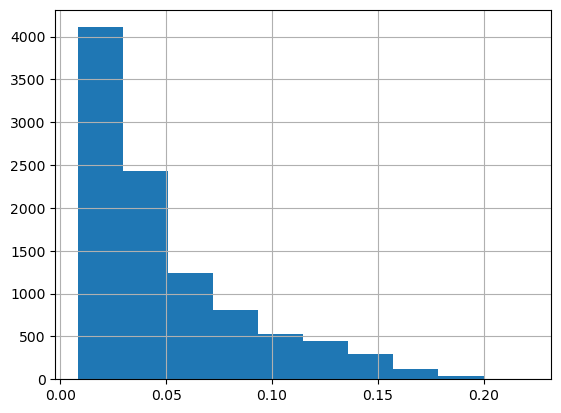

In [35]:
df_final[df_final.n_arms == 4]['rho_eff'].hist()

In [39]:
# save final merged df 
data_savepath = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/data/ros-data-merged.txt'
df_final.to_csv(data_savepath, index=False, header=True)

In [42]:
# test read merged data
read_path = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/data/ros-data-merged.txt'
df = pd.read_csv(read_path)
print(df.shape)
df.head()

(70000, 11)


,id,a,c,f_r0,f_hp,f_h0,n_arms,sa,vol,sa_eff,rho_eff
0,35000,13.817545,23.540122,0.867449,0.961225,0.943525,7,33247.371151,181231.947690,0.576030,0.138993
1,35001,13.817545,23.540122,0.867449,0.961225,0.943525,7,33022.961732,184536.198465,0.560433,0.137205
2,35002,13.817545,23.540122,0.867449,0.961225,0.943525,7,33530.598131,187678.178569,0.585745,0.145727
3,35003,13.817545,23.540122,0.867449,0.961225,0.943525,7,32592.037777,166089.393327,0.543729,0.120358
4,35004,13.817545,23.540122,0.867449,0.961225,0.943525,7,32892.678757,179534.751064,0.583751,0.142747


# Scratch

In [ ]:
# find rosettes that were not created at all i.e., ros_create() error
# error code = -666
ros_create_err = df[df['sa'].isna()]
ros_create_err

In [ ]:
df_4 = df[df['vol']==-666]

In [ ]:
print(params_list[25954])